<a href="https://colab.research.google.com/github/td-02/Pet-pose-estimation/blob/main/YOLOv8l_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import os
import time
import json
import requests
from zipfile import ZipFile
import tarfile
from shutil import copyfile
from dataclasses import dataclass, field

import yaml
import glob

import random
import numpy as np
import pandas as pd
import cv2

from ultralytics import YOLO

import matplotlib.pyplot as plt

In [ ]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".tar"):
            with tarfile.open(save_path, "r") as tar:
                tar.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [ ]:
IMAGES_URL = r"http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
IMAGES_DIR = "Images"
IMAGES_TAR_PATH = os.path.join(os.getcwd(), f"{IMAGES_DIR}.tar")

ANNS_METADATA_URL = r"https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
ANNS_METADATA = "keypoint_definitions.csv"

# Download if dataset does not exists.
if not os.path.exists(IMAGES_DIR):
    download_and_unzip(IMAGES_URL, IMAGES_TAR_PATH)
    os.remove(IMAGES_TAR_PATH)

if not os.path.isfile(ANNS_METADATA):
    download_and_unzip(ANNS_METADATA_URL, ANNS_METADATA)

In [ ]:
ANN_PATH = "/StanfordExtra_v12.json"
JSON_PATH = os.path.join(ANN_PATH, "/StanfordExtra_v12.json")

with open(JSON_PATH) as file:
    json_data = json.load(file)

In [ ]:
train_ids = np.load(os.path.join(ANN_PATH,
                                 "/train_stanford_StanfordExtra_v12.npy"))
val_ids = np.load(os.path.join(ANN_PATH,
                               "/test_stanford_StanfordExtra_v12.npy"))

print(f"Train Samples: {len(train_ids)}")
print(f"Validation Samples: {len(val_ids)}")

Train Samples: 6773
Validation Samples: 1703


In [ ]:
DATA_DIR = "animal-pose-data"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)

In [ ]:
train_json_data = []
for train_id in train_ids:
    train_json_data.append(json_data[train_id])

val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])

In [ ]:
for data in train_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(TRAIN_IMG_PATH, filename))


for data in val_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(VALID_IMG_PATH, filename))

In [ ]:
CLASS_ID = 0

In [ ]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.
    vis_ones = np.where(lm_kpts[:, -1] == 1.)
    lm_kpts[vis_ones, -1] = 2.

    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    norm_kps_per_img[:, :-1]  = norm_kps_per_img[:, :-1] / res_lm_array

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [ ]:
def create_yolo_txt_files(json_data, LABEL_PATH):

    for data in json_data:

        IMAGE_ID = data["img_path"].split("/")[-1].split(".")[0]

        IMG_WIDTH, IMG_HEIGHT = data["img_width"], data["img_height"]

        landmark_kpts  = np.nan_to_num(np.array(data["joints"], dtype=np.float32))
        landmarks_bboxes = np.array(data["img_bbox"], dtype=np.float32)

        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = IMAGE_ID+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

In [ ]:
create_yolo_txt_files(train_json_data, TRAIN_LABEL_PATH)
create_yolo_txt_files(val_json_data, VALID_LABEL_PATH)

In [ ]:
ann_meta_data = pd.read_csv("keypoint_definitions.csv")
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

In [ ]:
train_images = os.listdir(TRAIN_IMG_PATH)
valid_images = os.listdir(VALID_IMG_PATH)

print(f"Training images: {len(train_images)}, Validation Images: {len(valid_images)}")

Training images: 6773, Validation Images: 1703


In [ ]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [ ]:
def draw_boxes(image, detections, class_name = "dog", score=None, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, xmax, ymax = detections[:4].astype("int").tolist()
    conf = round(float(detections[-1]),2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)

    display_text = f"{class_name}"

    if score is not None:
        display_text+=f": {score:.2f}"

    (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                   cv2.FONT_HERSHEY_SIMPLEX,
                                                   font_size, 2)

    cv2.rectangle(image,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color=color, thickness=-1)

    image = cv2.putText(
                    image,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (0, 0, 0),
                    2, lineType=cv2.LINE_AA,
                )

    return image

In [ ]:
def visualize_annotations(image, box_data, keypoints_data):

    image = image.copy()

    shape_multiplier = np.array(image.shape[:2][::-1]) # (W, H).
    # Final absolute coordinates (xmin, ymin, xmax, ymax).
    denorm_boxes = np.zeros_like(box_data)

    # De-normalize center coordinates from YOLO to (xmin, ymin).
    denorm_boxes[:, :2] = (shape_multiplier/2.) * (2*box_data[:,:2] - box_data[:,2:])

    # De-normalize width and height from YOLO to (xmax, ymax).
    denorm_boxes[:, 2:] = denorm_boxes[:,:2] + box_data[:,2:]*shape_multiplier

    for boxes, kpts in zip(denorm_boxes, keypoints_data):
        # De-normalize landmark coordinates.
        kpts[:, :2]*= shape_multiplier
        image = draw_boxes(image, boxes)
        image = draw_landmarks(image, kpts)

    return image

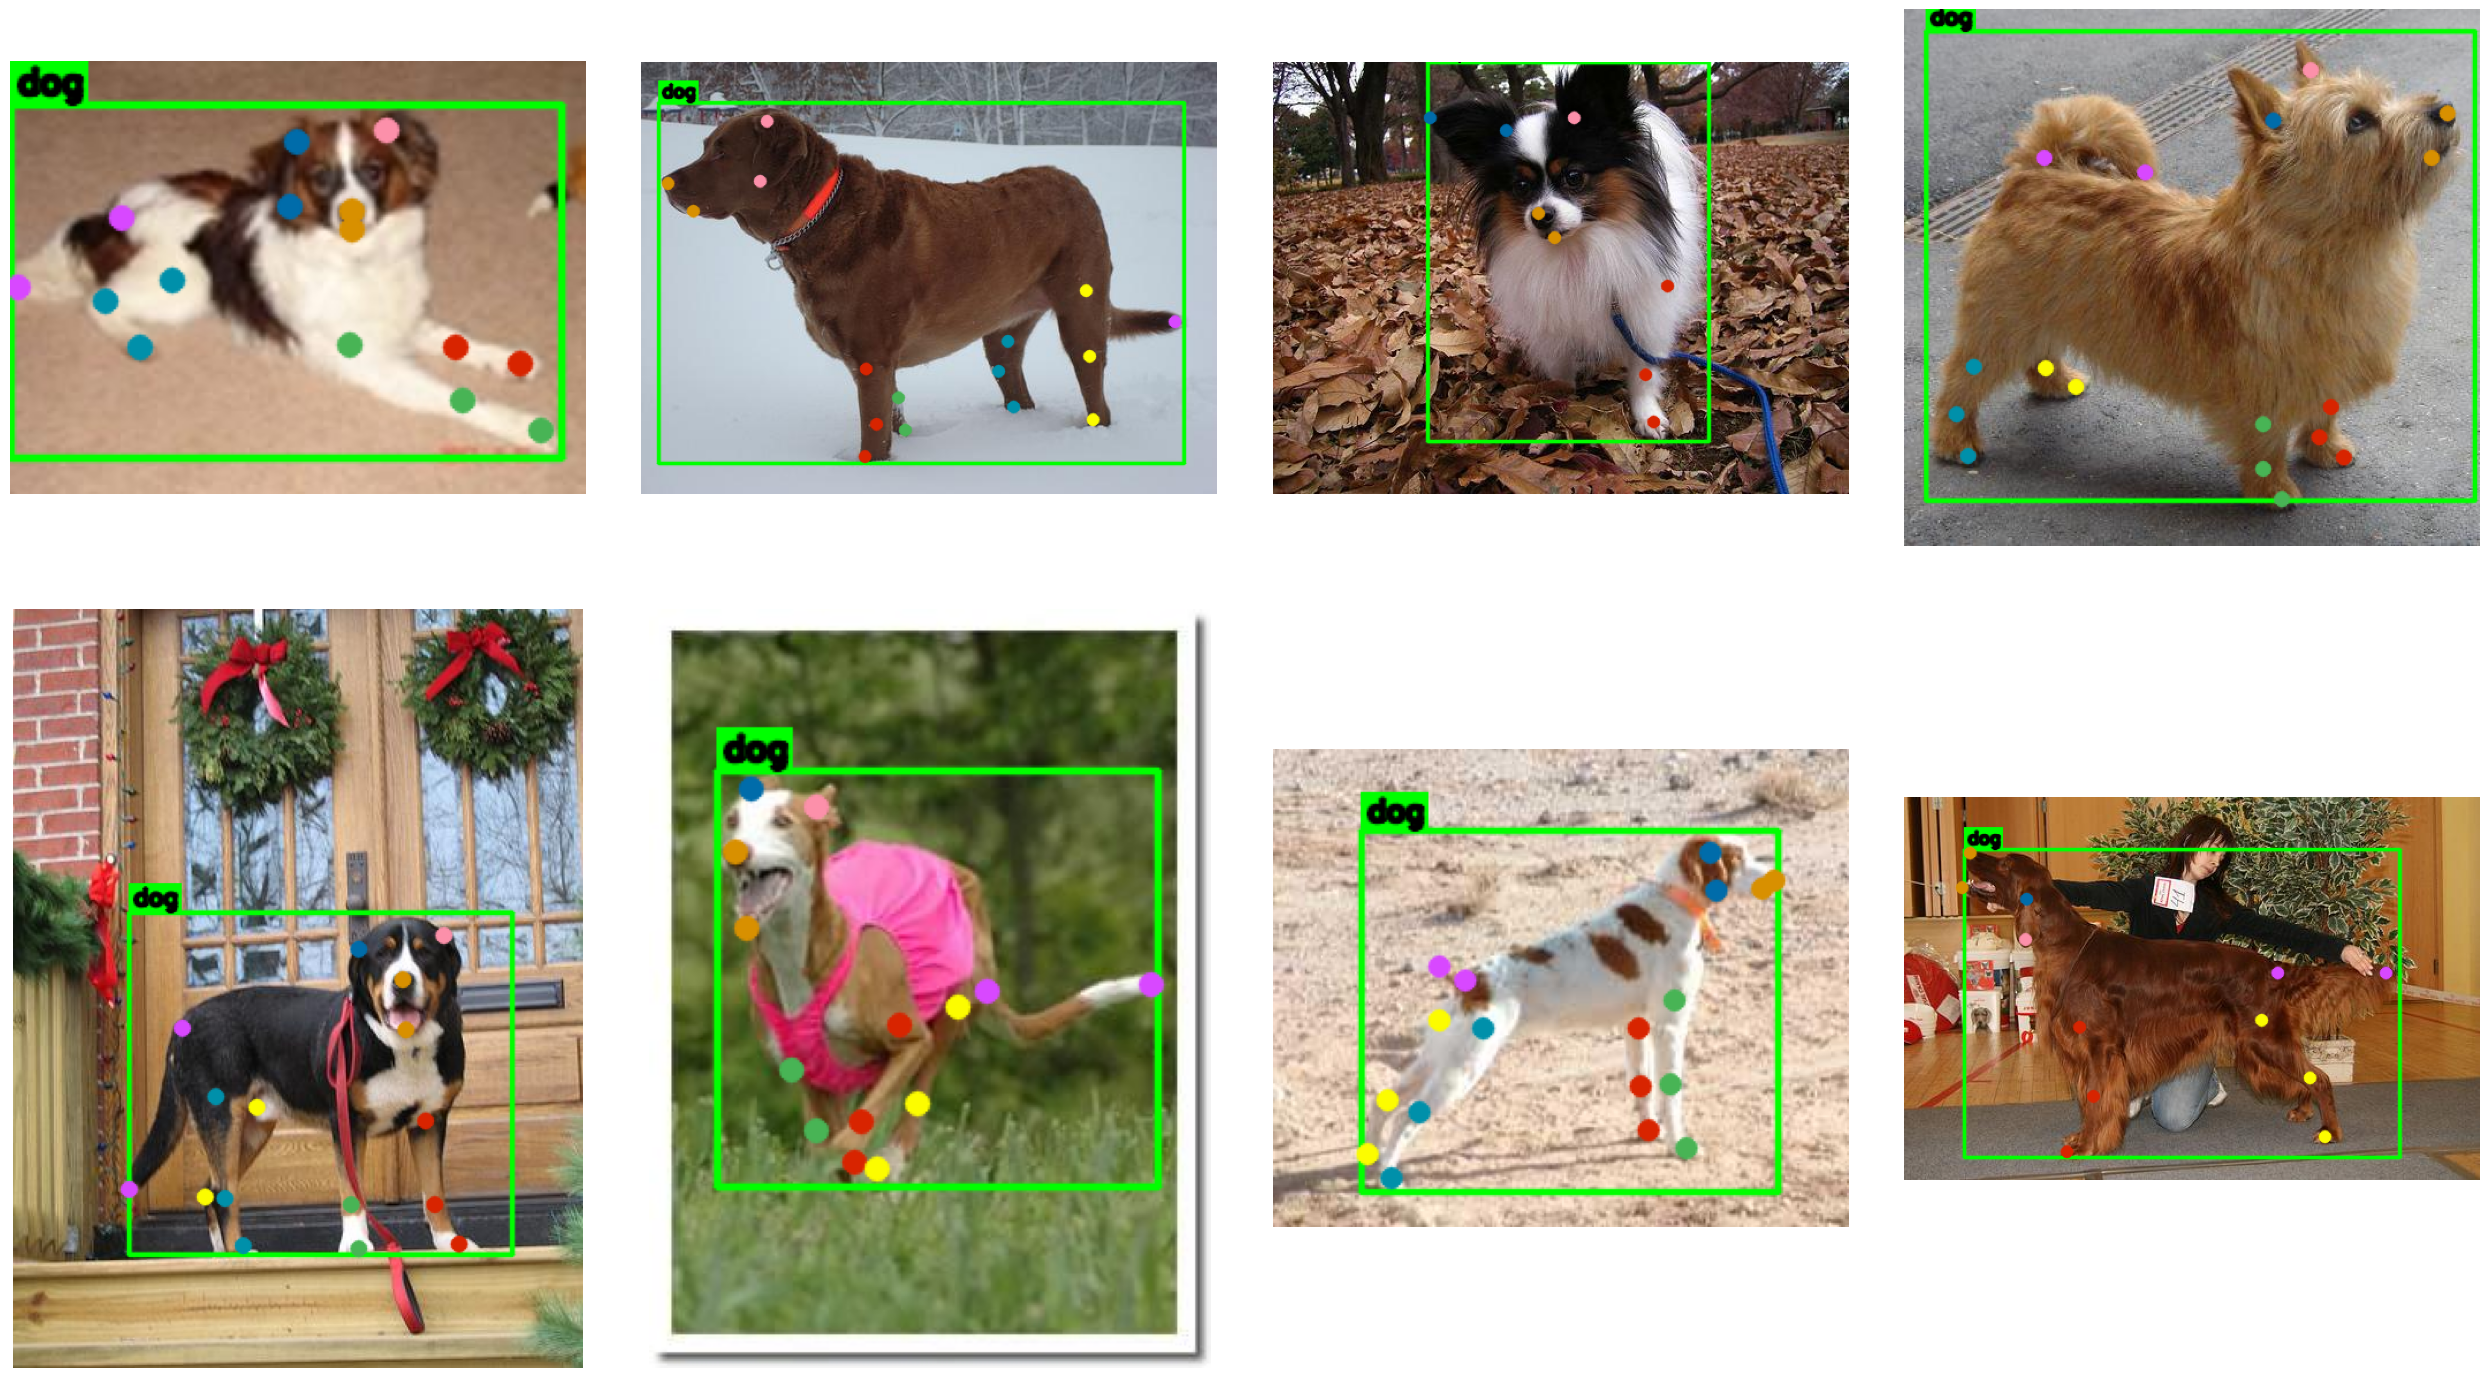

In [ ]:
IMAGE_FILES = os.listdir(TRAIN_IMG_PATH)
NUM_LANDMARKS = 24

num_samples = 8
num_rows = 2
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(45)
random.shuffle(IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(IMAGE_FILES[:num_samples], ax.flat)):

    image = cv2.imread(os.path.join(TRAIN_IMG_PATH, file))

    # Obtain the txt file for the corresponding image file.
    filename = file.split(".")[0]
    # Split each object instance in separate lists.
    with open(os.path.join(TRAIN_LABEL_PATH, filename+".txt"), "r") as file:
        label_data = [x.split() for x in file.read().strip().splitlines() if len(x)]

    label_data = np.array(label_data, dtype=np.float32)

    # YOLO BBox instances in [x-center, y-center, width, height] in normalized form.
    box_instances = label_data[:,1:5]
    # Shape: (N, 4), where, N = #instances per-image

    # Kpt instances.
    # Filter keypoints based on visibility.
    instance_kpts = []
    kpts_data = label_data[:,5:].reshape(-1, NUM_LANDMARKS, 3)

    for inst_kpt in kpts_data:
        vis_ids = np.where(inst_kpt[:, -1]>0.)[0]
        vis_kpts = inst_kpt[vis_ids][:,:2]
        vis_kpts = np.concatenate([vis_kpts, np.expand_dims(vis_ids, axis=-1)], axis=-1)
        instance_kpts.append(vis_kpts)

    image_ann = visualize_annotations(image, box_instances, instance_kpts)
    axis.imshow(image_ann[...,::-1])
    axis.axis("off")


plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();

In [ ]:
from dataclasses import dataclass, field

@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "animal-keypoints.yaml"
    MODEL:          str = "yolov8l-pose.pt"  # Updated model name to yolov8l-pose.pt
    EPOCHS:         int = 150  # Increased number of epochs for better convergence
    KPT_SHAPE:      tuple = (24, 3)
    PROJECT:        str = "Animal_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:   dict = field(default_factory=lambda: {0: "dog"})


In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0 # Turn off horizontal flip.

In [ ]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [ ]:
current_dir = os.getcwd()

data_dict = dict(
                path      = os.path.join(current_dir, DATA_DIR),
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

In [ ]:
pose_model = model = YOLO(train_config.MODEL)

pose_model.train(data    = train_config.DATASET_YAML,
            epochs       = train_config.EPOCHS,
            imgsz        = data_config.IMAGE_SIZE,
            batch        = data_config.BATCH_SIZE,
            project      = train_config.PROJECT,
            name         = train_config.NAME,
            close_mosaic = data_config.CLOSE_MOSAIC,
            mosaic       = data_config.MOSAIC,
            fliplr       = data_config.FLIP_LR
           )

100%|██████████| 85.3M/85.3M [00:00<00:00, 318MB/s]


Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8l-pose.pt, data=animal-keypoints.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Animal_Keypoints, name=yolov8l-pose_150_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 22.6MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[24, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1 

100%|██████████| 6.23M/6.23M [00:00<00:00, 98.9MB/s]


AMP: checks passed ✅


train: Scanning /content/animal-pose-data/train/labels... 6773 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6773/6773 [00:05<00:00, 1222.99it/s]

train: WARNING ⚠️ /content/animal-pose-data/train/images/n02089973_2054.jpg: corrupt JPEG restored and saved


train: New cache created: /content/animal-pose-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/animal-pose-data/valid/labels... 1703 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1703/1703 [00:03<00:00, 538.27it/s] 

val: WARNING ⚠️ /content/animal-pose-data/valid/images/n02089973_1763.jpg: corrupt JPEG restored and saved
val: New cache created: /content/animal-pose-data/valid/labels.cache


Plotting labels to Animal_Keypoints/yolov8l-pose_150_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 103 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to Animal_Keypoints/yolov8l-pose_150_epochs
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/150      11.8G     0.7015      10.11     0.6637     0.6893      1.318          7        640: 100%|██████████| 424/424 [05:50<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:33<00:00,  1.61it/s]

                   all       1703       1703      0.932      0.975       0.97      0.836      0.014     0.0123     0.0026   0.000345



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/150      11.3G     0.6948      7.913     0.5878     0.5498      1.283          7        640: 100%|██████████| 424/424 [05:45<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.72it/s]

                   all       1703       1703      0.919      0.953      0.975      0.798      0.134       0.14      0.031    0.00454



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/150      11.5G     0.8395      7.444     0.5556     0.6817      1.395         11        640: 100%|██████████| 424/424 [05:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.67it/s]

                   all       1703       1703      0.915      0.901      0.953       0.71      0.168      0.151      0.039    0.00569



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/150      11.4G      0.984      7.337     0.5405     0.8095      1.506          9        640: 100%|██████████| 424/424 [05:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]


                   all       1703       1703      0.852       0.88      0.914      0.628      0.213      0.157     0.0595    0.00832

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/150      11.3G     0.9478      7.007      0.529     0.7719      1.469          5        640: 100%|██████████| 424/424 [05:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.71it/s]

                   all       1703       1703      0.906      0.897      0.944      0.688      0.335      0.302      0.173     0.0308



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/150      11.3G     0.9086      6.728     0.5199     0.7217      1.432          5        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.65it/s]


                   all       1703       1703      0.922      0.939      0.966      0.758      0.431      0.396      0.272     0.0546

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/150      11.4G     0.8752       6.46     0.5123     0.6897        1.4          5        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]

                   all       1703       1703      0.934      0.933      0.963      0.768      0.492      0.432      0.306     0.0583



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/150      11.5G     0.8366      6.178      0.504     0.6595      1.362          5        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.73it/s]

                   all       1703       1703      0.929      0.965      0.976      0.789      0.556      0.506      0.396     0.0857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/150      11.5G      0.805      6.013     0.5001     0.6306      1.328         14        640: 100%|██████████| 424/424 [05:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.71it/s]

                   all       1703       1703      0.935      0.961      0.977      0.801       0.55      0.521      0.428     0.0965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/150      11.5G     0.7936        5.9     0.4928     0.6075      1.327          8        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.71it/s]

                   all       1703       1703      0.921      0.941      0.971      0.773      0.559      0.492      0.409     0.0957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/150      11.3G     0.7684      5.812      0.488     0.5954      1.299          6        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.67it/s]


                   all       1703       1703       0.95      0.955      0.983      0.824      0.633      0.604      0.503      0.125

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/150      11.3G     0.7384      5.602      0.481     0.5694      1.275         12        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]

                   all       1703       1703      0.952      0.948      0.982      0.824      0.685      0.646      0.592      0.154



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/150      11.3G     0.7401      5.534      0.475     0.5674      1.268         11        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.69it/s]

                   all       1703       1703      0.942      0.971      0.983      0.826      0.665      0.658       0.57      0.154



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/150      11.3G     0.7147      5.447     0.4704     0.5497      1.252          7        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.73it/s]

                   all       1703       1703      0.944      0.959      0.984      0.824      0.681       0.64      0.563      0.149



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/150      11.3G     0.7216      5.324     0.4632      0.549       1.26         11        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.73it/s]

                   all       1703       1703      0.958       0.96      0.987       0.85      0.738      0.708      0.649      0.188



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/150      11.4G     0.7074      5.275     0.4572     0.5354      1.243         11        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.69it/s]

                   all       1703       1703      0.957      0.965      0.986      0.846      0.737      0.713      0.656      0.191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/150      11.5G     0.6928       5.18     0.4516     0.5284      1.233          5        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:32<00:00,  1.68it/s]

                   all       1703       1703      0.953      0.965      0.988      0.859       0.73      0.706      0.662      0.194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/150      11.5G     0.6841      5.052      0.446     0.5067      1.224          6        640: 100%|██████████| 424/424 [05:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]

                   all       1703       1703      0.945       0.97      0.983      0.858      0.752      0.717      0.665      0.203



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/150      11.4G     0.6782      5.028      0.443     0.5003      1.217         11        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]


                   all       1703       1703      0.945      0.972      0.985      0.855      0.742       0.72      0.663      0.202

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/150      11.4G     0.6708      4.931     0.4371     0.4934      1.209          7        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.72it/s]

                   all       1703       1703       0.95      0.968      0.985      0.858      0.762      0.755      0.683       0.21



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/150      11.4G     0.6627      4.914      0.434     0.4982      1.199          5        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.72it/s]

                   all       1703       1703      0.941      0.977      0.989      0.871      0.762      0.757       0.71      0.235



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/150      11.3G     0.6411      4.848     0.4336     0.4833      1.188          6        640: 100%|██████████| 424/424 [05:41<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:31<00:00,  1.73it/s]

                   all       1703       1703      0.956      0.963      0.987      0.866      0.781      0.775      0.718      0.233



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/150      11.4G     0.6402      4.787     0.4331     0.4762      1.182         32        640:  13%|█▎        | 54/424 [00:43<04:58,  1.24it/s]

In [ ]:
ckpt_path  = os.path.join(train_config.PROJECT, train_config.NAME, "weights", "best.pt")
model_pose = YOLO(ckpt_path)

metrics = model_pose.val()

NameError: name 'os' is not defined

In [ ]:
def prepare_predictions(
    image_dir_path,
    image_filename,
    model,
    BOX_IOU_THRESH = 0.55,
    BOX_CONF_THRESH=0.30,
    KPT_CONF_THRESH=0.68):

    image_path = os.path.join(image_dir_path, image_filename)
    image = cv2.imread(image_path).copy()

    results = model.predict(image_path, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

    if not len(results.boxes.xyxy):
        return image

    # Get the predicted boxes, conf scores and keypoints.
    pred_boxes = results.boxes.xyxy.numpy()
    pred_box_conf = results.boxes.conf.numpy()
    pred_kpts_xy = results.keypoints.xy.numpy()
    pred_kpts_conf = results.keypoints.conf.numpy()

    # Draw predicted bounding boxes, conf scores and keypoints on image.
    for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
        kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
        filter_kpts = kpts[kpts_ids]
        filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
        image = draw_boxes(image, boxes, score=score)
        image = draw_landmarks(image, filter_kpts)

    return image

In [ ]:
VAL_IMAGE_FILES = os.listdir(VALID_IMG_PATH)

num_samples = 9
num_rows = 3
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(90)
random.shuffle(VAL_IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(VAL_IMAGE_FILES[:num_samples], ax.flat)):

    image_pred = prepare_predictions(VALID_IMG_PATH, file, model_pose)
    axis.imshow(image_pred[...,::-1])
    axis.axis("off")

plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();